In [4]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

##### Copyright 2019 The TensorFlow Authors.

# Time series forecasting

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/structured_data/time_series"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial is an introduction to time series forecasting using Recurrent Neural Networks (RNNs). This is covered in two parts: first, you will forecast a univariate time series, then you will forecast a multivariate time series.

In [5]:
import tensorflow as tf
import matplotlib.dates as mdates
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import gc
import sys

print(f"Tensorflow Version: {tf.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"Numpy Version: {np.__version__}")
print(f"System Version: {sys.version}")

mpl.rcParams['figure.figsize'] = (17, 5)
mpl.rcParams['axes.grid'] = False
sns.set_style("whitegrid")

notebookstart= time.time()

Tensorflow Version: 2.1.0
Pandas Version: 0.25.3
Numpy Version: 1.18.1
System Version: 3.6.6 |Anaconda, Inc.| (default, Oct  9 2018, 12:34:16) 
[GCC 7.3.0]


## The weather dataset
This tutorial uses a <a href="https://www.bgc-jena.mpg.de/wetter/" class="external">[weather time series dataset</a> recorded by the <a href="https://www.bgc-jena.mpg.de" class="external">Max Planck Institute for Biogeochemistry</a>.

This dataset contains 14 different features such as air temperature, atmospheric pressure, and humidity. These were collected every 10 minutes, beginning in 2003. For efficiency, you will use only the data collected between 2009 and 2016. This section of the dataset was prepared by François Chollet for his book [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python).

In [6]:
# Data Loader Parameters
BATCH_SIZE = 256
BUFFER_SIZE = 10000
TRAIN_SPLIT = 300000

# LSTM Parameters
EVALUATION_INTERVAL = 200
EPOCHS = 8
PATIENCE = 5

# Reproducibility
SEED = 13
tf.random.set_seed(SEED)

In [7]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13574144/13568290 [==============================] - 0s 0us/step


In [8]:
df = pd.read_csv(csv_path)
print("DataFrame Shape: {} rows, {} columns".format(*df.shape))

DataFrame Shape: 420551 rows, 15 columns


Let's take a glance at the data.

In [9]:
header=list(pd.read_csv(csv_path,index_col=0,nrows=0))
display(df.head())

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


As you can see above, an observation is recorded every 10 minutes. This means that, for a single hour, you will have 6 observations. Similarly, a single day will contain 144 (6x24) observations. 

Given a specific time, let's say you want to predict the temperature 6 hours in the future. In order to make this prediction, you choose to use 5 days of observations. Thus, you would create a window containing the last 720(5x144) observations to train the model. Many such configurations are possible, making this dataset a good one to experiment with.

The function below returns the above described windows of time for the model to train on. The parameter `history_size` is the size of the past window of information. The `target_size` is how far in the future does the model need to learn to predict. The `target_size` is the label that needs to be predicted.

In [10]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
        
    return np.array(data), np.array(labels)



In both the following tutorials, the first 300,000 rows of the data will be the training dataset, and there remaining will be the validation dataset. This amounts to ~2100 days worth of training data.

Setting seed to ensure reproducibility.

## Part 1: Forecast a univariate time series
First, you will train a model using only a single feature (temperature), and use it to make predictions for that value in the future.

Let's first extract only the temperature from the dataset.

In [11]:
parametre=input(header)
uni_data = df[parametre]
uni_data.index = df['Date Time']
date_time = df['Date Time']
uni_data.head()

['p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)', 'wd (deg)']p (mbar)


Date Time
01.01.2009 00:10:00    996.52
01.01.2009 00:20:00    996.57
01.01.2009 00:30:00    996.53
01.01.2009 00:40:00    996.51
01.01.2009 00:50:00    996.51
Name: p (mbar), dtype: float64

Choose the variable you want to calculate

Let's observe how this data looks across time.

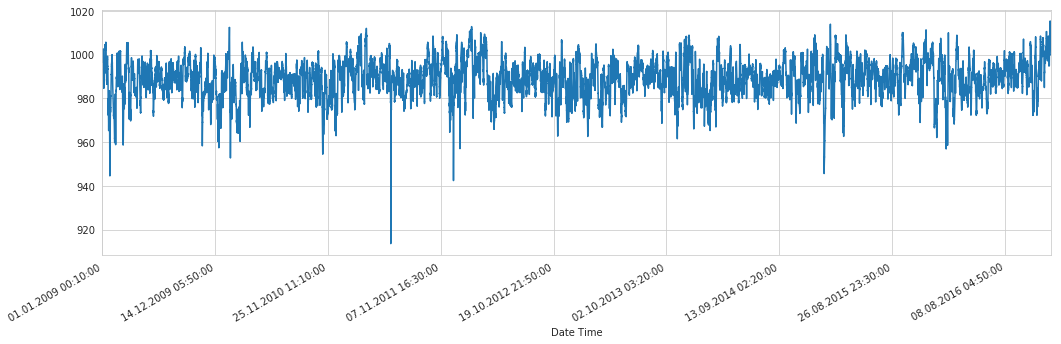

In [12]:
uni_data.plot(subplots=True)
plt.show()
uni_data = uni_data.values

It is important to scale features before training a neural network. Standardization is a common way of doing this scaling by subtracting the mean and dividing by the standard deviation of each feature.You could also use a `tf.keras.utils.normalize` method that rescales the values into a range of [0,1].

Note: The mean and standard deviation should only be computed using the training data.

In [13]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
uni_data1 = (uni_data-uni_train_mean)/uni_train_std

Let's standardize the data.

Let's now create the data for the univariate model. For part 1, the model will be given the last 20 recorded temperature observations, and needs to learn to predict the temperature at the next time step. 

In [14]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(dataset=uni_data,
                                           start_index=0,
                                           end_index=TRAIN_SPLIT,
                                           history_size=univariate_past_history,
                                           target_size=univariate_future_target)
x_val_uni, y_val_uni = univariate_data(dataset=uni_data,
                                       start_index=TRAIN_SPLIT,
                                       end_index=None,
                                       history_size=univariate_past_history,
                                       target_size=univariate_future_target)

In [15]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni1, y_train_uni1 = univariate_data(dataset=uni_data1,
                                           start_index=0,
                                           end_index=TRAIN_SPLIT,
                                           history_size=univariate_past_history,
                                           target_size=univariate_future_target)
x_val_uni1, y_val_uni1 = univariate_data(dataset=uni_data1,
                                       start_index=TRAIN_SPLIT,
                                       end_index=None,
                                       history_size=univariate_past_history,
                                       target_size=univariate_future_target)

This is what the `univariate_data` function returns.

In [16]:
print("In:")
print(uni_data.shape)
print(uni_data[:5])
print("\nOut")
print(x_train_uni.shape)
print(x_train_uni.shape[0] / uni_data.shape[0])
print ('Single window of past history')
print (len(x_train_uni[:]))
print ('\n Target temperature to predict')
print (y_train_uni[0])

In:
(420551,)
[996.52 996.57 996.53 996.51 996.51]

Out
(299980, 20, 1)
0.7133023105402199
Single window of past history
299980

 Target temperature to predict
997.08


Now that the data has been created, let's take a look at a single example. The information given to the network is given in blue, and it must predict the value at the red cross.

In [17]:
def create_time_steps(length):
  return list(range(-length, 0))

In [18]:
def show_plot(plot_data,start,delta, title,label_min,label_max):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps= date_time[univariate_future_target:univariate_past_history]
  time_steps=start
  if delta:
    future = delta
  else:
    future = 0
  #plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d.%m.%y %H:%M:%S'))
  #plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=5))
  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(delta, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlabel('Time-Step')
  plt.ylabel(parametre)
  plt.gcf().autofmt_xdate()
  plt.grid(True)
  plt.ylim(label_min,label_max)
  return plt

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

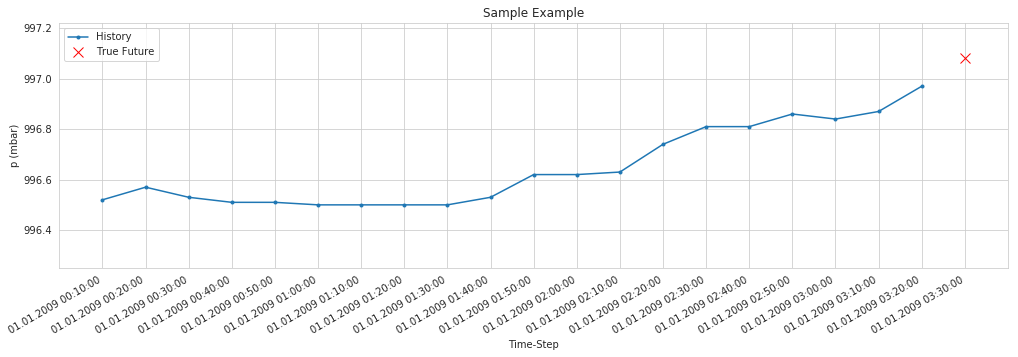

In [19]:
show_plot([x_train_uni[0], y_train_uni[0]],date_time[univariate_future_target:univariate_past_history],date_time[univariate_past_history], 'Sample Example',x_train_uni[0].min()-0.25,x_train_uni[0].max()+0.25)

### Baseline
Before proceeding to train a model, let's first set a simple baseline. Given an input point, the baseline method looks at all the history and predicts the next point to be the average of the last 20 observations.

In [20]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

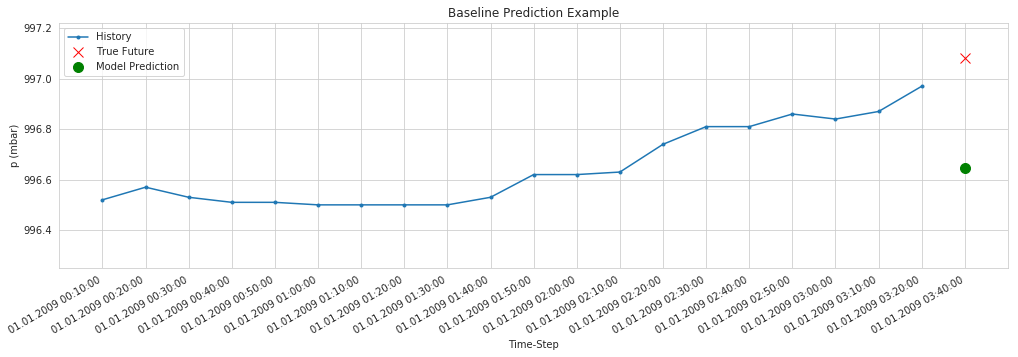

In [21]:
show_plot([x_train_uni[0], y_train_uni[0],baseline(x_train_uni[0])],date_time[univariate_future_target:univariate_past_history], date_time[univariate_past_history+1],
           'Baseline Prediction Example',x_train_uni[0].min()-0.25,x_train_uni[0].max()+0.25)

Let's see if you can beat this baseline using a recurrent neural network.

### Recurrent neural network

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state summarizing the information they've seen so far. For more details, read the [RNN tutorial](https://www.tensorflow.org/tutorials/sequences/recurrent). In this tutorial, you will use a specialized RNN layer called Long Short Term Memory ([LSTM](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/LSTM))

Let's now use `tf.data` to shuffle, batch, and cache the dataset.

In [ ]:
train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni1, y_train_uni1))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni1, y_val_uni1))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

The following visualisation should help you understand how the data is represented after batching.

![Time Series](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/time_series.png?raw=1)

In [ ]:
x_train_uni1.shape

You will see the LSTM requires the input shape of the data it is being given.

In [ ]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni1.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')
input_shape=x_train_uni[-2:]

Let's make a sample prediction, to check the output of the model. 

In [ ]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

Let's train the model now. Due to the large size of the dataset, in the interest of saving time, each epoch will only run for 200 steps, instead of the complete training data as normally done.

In [26]:
early_stopping = EarlyStopping(monitor='val_loss', patience = 3, restore_best_weights=True)
simple_lstm_model.fit(train_univariate,
                      epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate,
                      callbacks=[early_stopping],
                      validation_steps=50)

200/200 [==============================] - 3s 16ms/step - loss: 0.0196 - val_loss: 0.0124
Epoch 7/8
200/200 [==============================] - 3s 17ms/step - loss: 0.0187 - val_loss: 0.0118
Epoch 8/8
200/200 [==============================] - 4s 20ms/step - loss: 0.0139 - val_loss: 0.0108


#### Predict using the simple LSTM model
Now that you have trained your simple LSTM, let's try and make a few predictions.


tf.Tensor(
[[993.16]
 [993.17]
 [993.25]
 [993.3 ]
 [993.29]
 [993.42]
 [993.53]
 [993.45]
 [993.39]
 [993.21]
 [993.3 ]
 [993.42]
 [993.42]
 [993.42]
 [993.39]
 [993.31]
 [993.27]
 [993.42]
 [993.41]
 [993.31]], shape=(20, 1), dtype=float64)


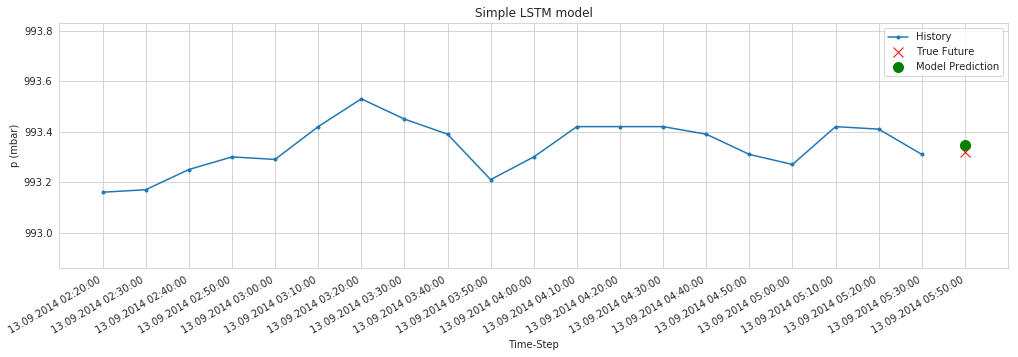


tf.Tensor(
[[992.67]
 [992.57]
 [992.5 ]
 [992.55]
 [992.55]
 [992.55]
 [992.55]
 [992.46]
 [992.42]
 [992.41]
 [992.34]
 [992.29]
 [992.31]
 [992.34]
 [992.3 ]
 [992.31]
 [992.3 ]
 [992.27]
 [992.22]
 [992.19]], shape=(20, 1), dtype=float64)


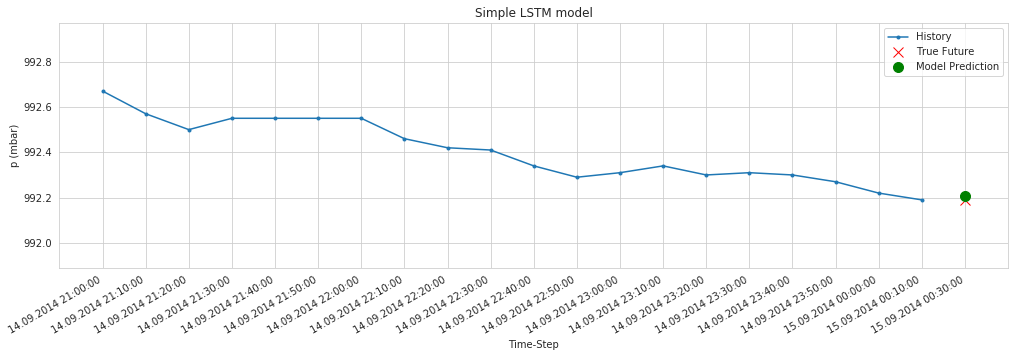


tf.Tensor(
[[989.84]
 [989.84]
 [989.82]
 [989.79]
 [989.83]
 [989.84]
 [989.76]
 [989.73]
 [989.72]
 [989.72]
 [989.69]
 [989.68]
 [989.65]
 [989.62]
 [989.59]
 [989.6 ]
 [989.57]
 [989.56]
 [989.64]
 [989.74]], shape=(20, 1), dtype=float64)


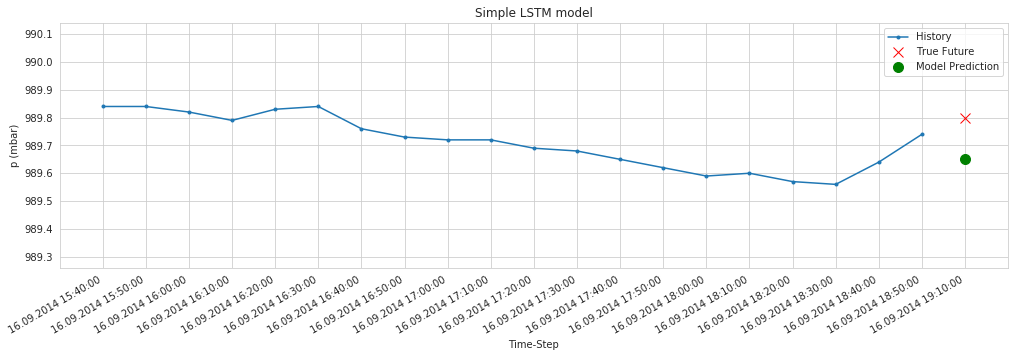

In [27]:
i=0
for x, y in val_univariate.take(3):
  i=i+1
  step=[0,int(simple_lstm_model.predict(x).shape[0]),simple_lstm_model.predict(x).shape[0]*2]
  x1= x*uni_train_std + uni_train_mean
  y1=y*uni_train_std + uni_train_mean
  z=simple_lstm_model.predict(x)[0]*uni_train_std + uni_train_mean
  date_history=date_time[TRAIN_SPLIT+step[i-1]:TRAIN_SPLIT+step[i-1]+univariate_past_history]
  date_model=date_time[TRAIN_SPLIT+univariate_past_history+step[i-1]+1]
  plot = show_plot([x1[0].numpy(), y1[0].numpy(),
                    z],date_history ,date_model, 'Simple LSTM model',x1[0].numpy().min()-0.3,x1[0].numpy().max()+0.3)
  plot.show()

This looks better than the baseline. Now that you have seen the basics, let's move on to part two, where you will work with a multivariate time series.

In [28]:
del simple_lstm_model, val_univariate, train_univariate

## Part 2: Forecast a multivariate time series

The original dataset contains fourteen features. For simplicity, this section considers only three of the original fourteen. The features used are air temperature, atmospheric pressure, and air density. 

To use more features, add their names to this list.

In [29]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

In [30]:
features = df[features_considered]
features.index = df['Date Time']
features.head()
date_time2=features.index 

Let's have a look at how each of these features vary across time.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa29057c9b0>,
      dtype=object)

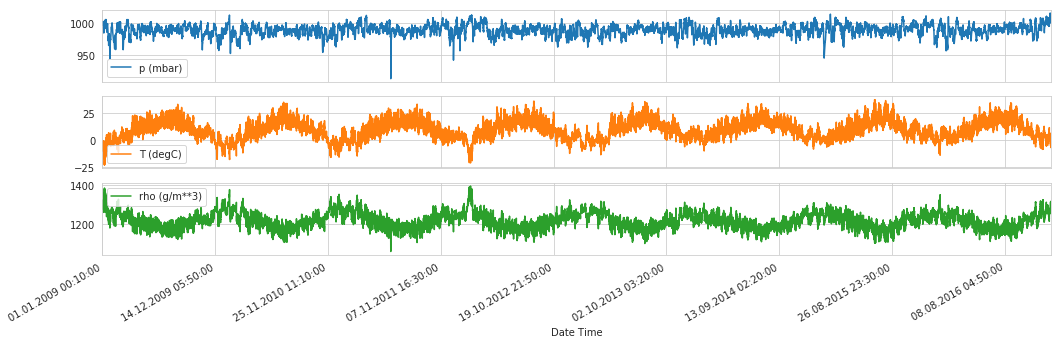

In [31]:
features.plot(subplots=True)

As mentioned, the first step will be to standardize the dataset using the mean and standard deviation of the training data.

In [32]:
dataset1 = features.values
data_mean = dataset1[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset1[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset1-data_mean)/data_std

In [33]:
dataset = dataset 
display(pd.DataFrame(dataset, columns = features.columns, index= features.index).head())

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,0.955474,-1.997663,2.235079
01.01.2009 00:20:00,0.961545,-2.042819,2.285240
01.01.2009 00:30:00,0.956688,-2.054397,2.296006
01.01.2009 00:40:00,0.954259,-2.031241,2.270314
01.01.2009 00:50:00,0.954259,-2.026609,2.265665


### Single step model
In a single step setup, the model learns to predict a single point in the future based on some history provided.

The below function performs the same windowing task as above, however, here it samples the past observation based on the step size given.

In [34]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []
  #date_step=[]

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])
    #date_step.append(date_time[indices])
    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])
  return np.array(data),np.array(labels)

In this tutorial, the network is shown data from the last five (5) days, i.e. 720 observations that are sampled every hour. The sampling is done every one hour since a drastic change is not expected within 60 minutes. Thus, 120 observation represent history of the last five days.  For the single step prediction model, the label for a datapoint is the temperature 12 hours into the future. In order to create a label for this, the temperature after 72(12*6) observations is used.

In [35]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

Let's look at a single data-point.


In [36]:
print(x_train_single.shape[1])
print ('Single window of past history : {}'.format(x_train_single[0].shape))
print(x_train_single.shape[-2:])

120
Single window of past history : (120, 3)
(120, 3)


In [37]:
import datetime
stamps = pd.date_range(date_time[1],date_time[405002], freq=' H ')
date_1 = pd.to_datetime(date_time, format='%d.%m.%Y %H:%M:%S')

In [38]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [39]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

Let's check out a sample prediction.

In [40]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(256, 1)


In [41]:
print(f"Evaluation Threshold: {EVALUATION_INTERVAL}",
      f"Epochs: {EPOCHS}", sep="\n")

early_stopping = EarlyStopping(monitor='val_loss', patience = 3, restore_best_weights=True)
single_step_history = single_step_model.fit(train_data_single,
                                            epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            callbacks=[early_stopping],
                                            validation_steps=50)

Evaluation Threshold: 200
Epochs: 8
Train for 200 steps, validate for 50 steps
Epoch 1/8
200/200 [==============================] - 25s 126ms/step - loss: 0.3090 - val_loss: 0.2646
Epoch 2/8
200/200 [==============================] - 22s 109ms/step - loss: 0.2623 - val_loss: 0.2427
Epoch 3/8
200/200 [==============================] - 22s 109ms/step - loss: 0.2613 - val_loss: 0.2470
Epoch 4/8
200/200 [==============================] - 22s 112ms/step - loss: 0.2571 - val_loss: 0.2447
Epoch 5/8
200/200 [==============================] - 22s 110ms/step - loss: 0.2265 - val_loss: 0.2368
Epoch 6/8
200/200 [==============================] - 28s 140ms/step - loss: 0.2414 - val_loss: 0.2677
Epoch 7/8
200/200 [==============================] - 23s 113ms/step - loss: 0.2410 - val_loss: 0.2531
Epoch 8/8
200/200 [==============================] - 23s 115ms/step - loss: 0.2407 - val_loss: 0.2370


In [42]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

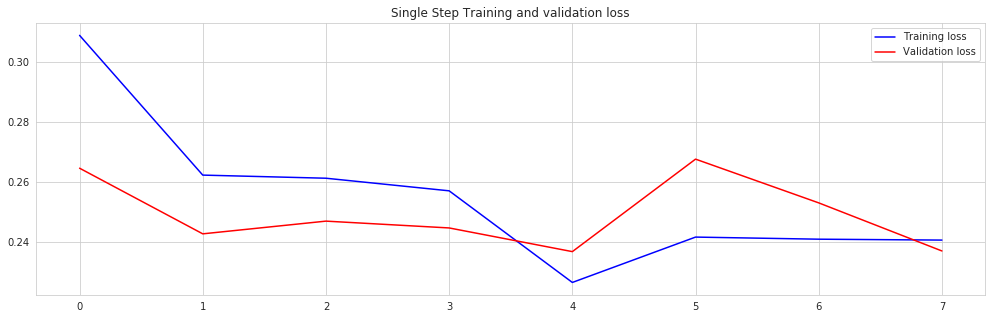

In [43]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

#### Predict a single step future
Now that the model is trained, let's make a few sample predictions. The model is given the history of three features over the past five days sampled every hour (120 data-points), since the goal is to predict the temperature, the plot only displays the past temperature. The prediction is made one day into the future (hence the gap between the history and prediction). 

In [44]:
from matplotlib.dates import DateFormatter
import datetime
rang= int(past_history/STEP)
def show_plot_1(plot_data,date_hystory,delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  rang= int(past_history/STEP)
  time_steps=date_hystory
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
      print(plot_data[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  #plt.xlim([time_steps,stamps[rang+20]])
  #plt.ylabel(header[features_considered])
  plt.xlabel('Time-Step')
  return plt


21.69
[20.844288]


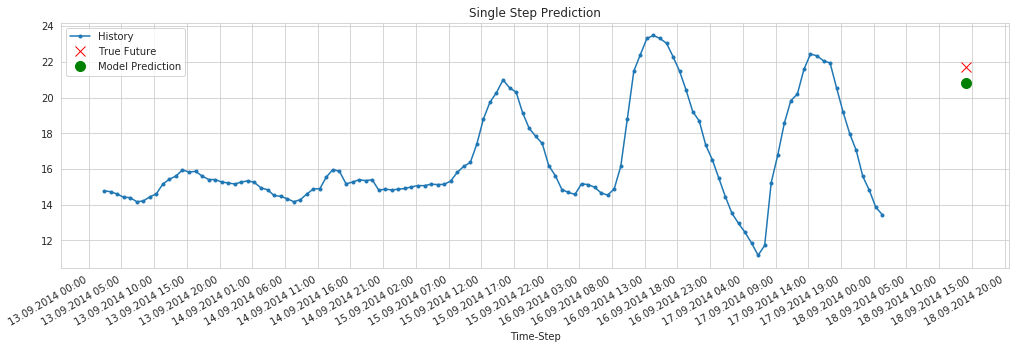

16.01
[16.056602]


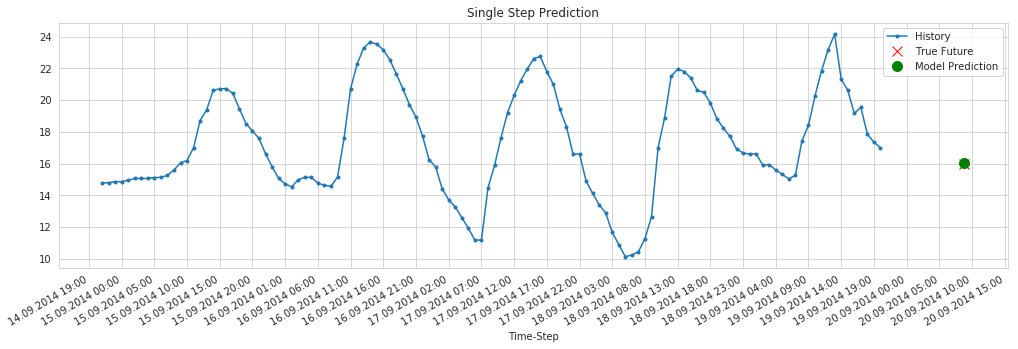

10.99
[11.340268]


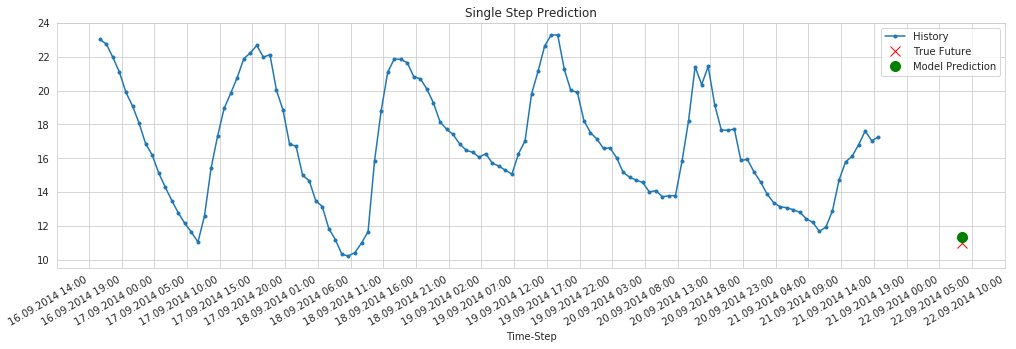

In [45]:
i=0
for x, y in val_data_single.take(3):
  i=i+1
  step=[0,single_step_model.predict(x).shape[0],single_step_model.predict(x).shape[0]*2]
  x1=x*data_std+data_mean
  y1=y*data_std[1]+data_mean[1]
  z=single_step_model.predict(x)[0]*data_std[1]+data_mean[1]
  date_starte=int(TRAIN_SPLIT+step[i-1])
  date_end=int(TRAIN_SPLIT+step[i-1]+past_history-1)
  date_hystory = pd.date_range(date_time[date_starte],date_time[date_end], freq=' H ')
  plot = show_plot_1([x1[0][:, 1].numpy(), y1[0].numpy(),z],date_hystory,
                     date_1[date_end+future_target],
                   'Single Step Prediction')
  plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=5))
  plt.gca().xaxis.set_major_formatter(DateFormatter("%d.%m.%Y %H:%M"))
  plt.gcf().autofmt_xdate()
  plt.ylim(min(x1[0][:, 1].numpy())-0.7,max(x1[0][:, 1].numpy())+0.7)
  plot.show()

In [46]:
del single_step_history, val_data_single, train_data_single

### Multi-Step model
In a multi-step prediction model, given a past history, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predict a sequence of the future.

For the multi-step model, the training data again consists of recordings over the past five days sampled every hour. However, here, the model needs to learn to predict the temperature for the next 12 hours. Since an obversation is taken every 10 minutes, the output is 72 predictions. For this task, the dataset needs to be prepared accordingly, thus the first step is just to create it again, but with a different target window.

In [47]:
past_history = 720
future_target = 72
STEP = 6

x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)



Let's check out a sample data-point.

In [48]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 3)

 Target temperature to predict : (72,)


In [49]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

Plotting a sample data-point.

In [50]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_out = len(true_future)
  num_in=stamps[:120]
  future_=future_target+past_history
  plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d-%m-%Y %H:%M"))
  plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
  plt.plot(num_in,(history[:, 1]), label='History')
  plt.plot(num_in,dataset1[:120,1],label='True History')
  plt.plot(date_1[past_history:future_], np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(date_1[past_history:future_], np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  #plt.ylabel(header[features_considered])
  plt.gcf().autofmt_xdate()
  plot.show()

In this plot and subsequent similar plots, the history and the future data are sampled every hour.

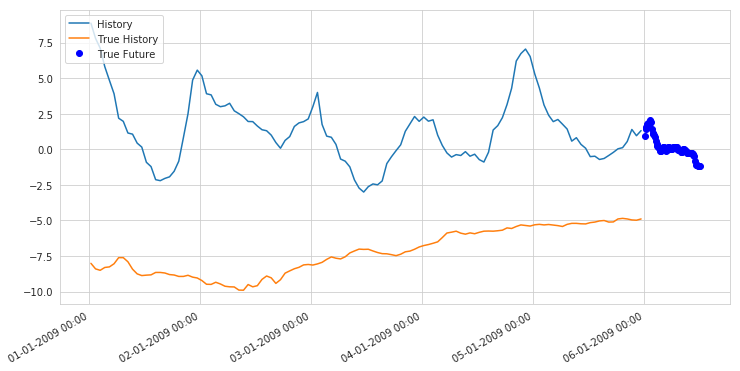

In [51]:
for x, y in train_data_multi.take(1):
  x1=x*data_std[1]+data_mean[1]
  y1=y*data_std[1]+data_mean[1]
  z=single_step_model.predict(x)[0]*data_std[1]+data_mean[1]
  multi_step_plot(x1[0], y1[0], np.array([0]))
  #plt.ylim(np.array(x1[0]).min()+0.25,np.array(x1[0]).max()+0.25)
  plot.show()


Since the task here is a bit more complicated than the previous task, the model now consists of two LSTM layers. Finally, since 72 predictions are made, the dense layer outputs 72 predictions.

In [52]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')
print(multi_step_model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 120, 32)           4608      
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_2 (Dense)              (None, 72)                1224      
Total params: 8,968
Trainable params: 8,968
Non-trainable params: 0
_________________________________________________________________
None


Let's see how the model predicts before it trains.

In [53]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

(256, 72)


In [54]:
early_stopping = EarlyStopping(monitor='val_loss', patience = 3, restore_best_weights=True)
multi_step_history = multi_step_model.fit(train_data_multi,
                                          epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=EVALUATION_INTERVAL,
                                          callbacks=[early_stopping])

Train for 200 steps, validate for 200 steps
Epoch 1/8
200/200 [==============================] - 54s 270ms/step - loss: 0.4965 - val_loss: 0.4044
Epoch 2/8
200/200 [==============================] - 54s 268ms/step - loss: 0.3470 - val_loss: 0.3575
Epoch 3/8
200/200 [==============================] - 51s 253ms/step - loss: 0.3294 - val_loss: 0.2831
Epoch 4/8
200/200 [==============================] - 52s 259ms/step - loss: 0.2425 - val_loss: 0.2383
Epoch 5/8
200/200 [==============================] - 60s 299ms/step - loss: 0.1966 - val_loss: 0.2327
Epoch 6/8
200/200 [==============================] - 53s 265ms/step - loss: 0.2056 - val_loss: 0.2323
Epoch 7/8
200/200 [==============================] - 54s 270ms/step - loss: 0.1979 - val_loss: 0.2253
Epoch 8/8
200/200 [==============================] - 53s 263ms/step - loss: 0.1960 - val_loss: 0.2288


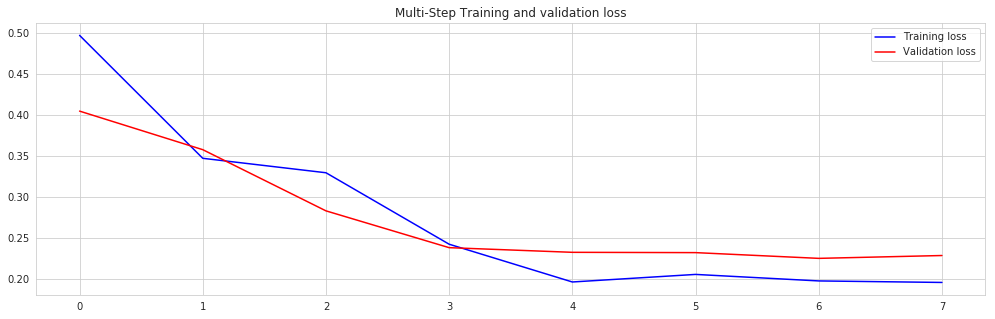

In [55]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

In [56]:
def multi_step_plot1(history, true_future, prediction,true_hisstory,date_prediction):
  plt.figure(figsize=(15, 6))
  plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d-%m-%Y %H:%M"))
  plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
  print(len(true_hisstory),len(np.array(history[:,1])))
  plt.plot(true_hisstory,np.array(history[:,1]), label='History')
  #plt.plot(num_in,true_hisstory,label='true_History')
  plt.plot(date_prediction, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(date_prediction, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  #plt.ylabel(header[features_considered])
  plt.gcf().autofmt_xdate()
  plot.show()

#### Predict a multi-step future
Let's now have a look at how well your network has learnt to predict the future.

120 120


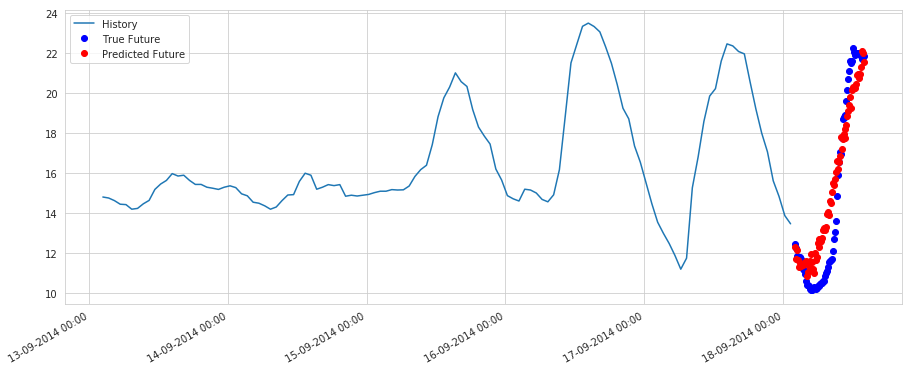

120 120


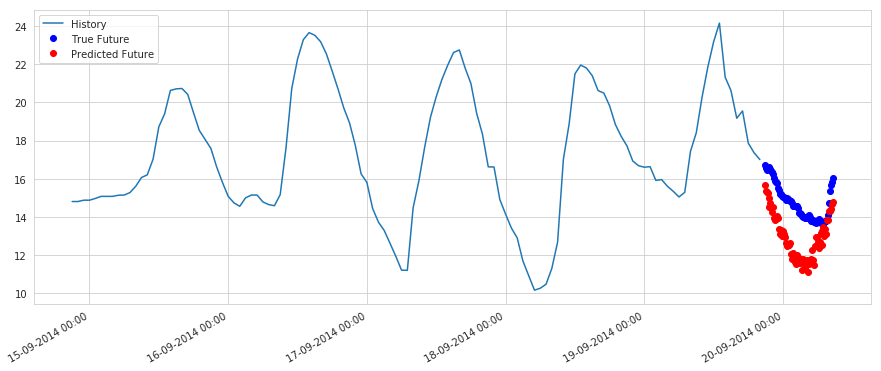

120 120


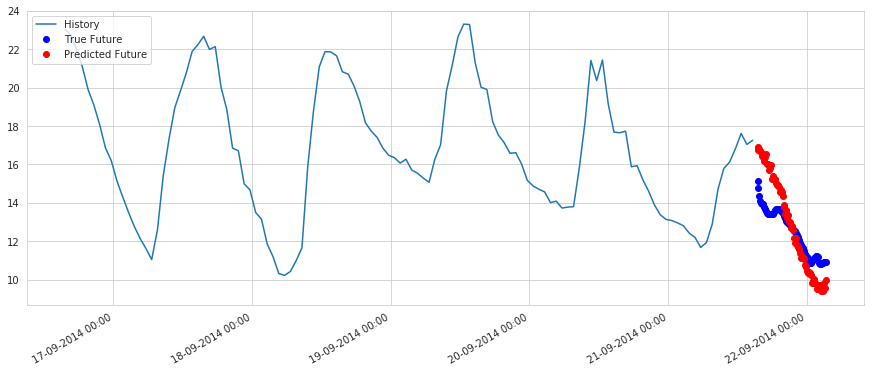

In [57]:
i=0
for x, y in val_data_multi.take(3):
  i=i+1
  step=[0,single_step_model.predict(x).shape[0],single_step_model.predict(x).shape[0]*2]
  date_starte=int(TRAIN_SPLIT+step[i-1])
  date_end=int(TRAIN_SPLIT+step[i-1]+past_history-1)
  date_history = pd.date_range(date_time2[date_starte],date_time[date_end], freq=' H ')
  date_preduction=date_1[date_end:date_end+future_target]
  x1=x*data_std+data_mean
  y1=y*data_std[1]+data_mean[1]
  z=multi_step_model.predict(x)[0]*data_std[1]+data_mean[1]
  multi_step_plot1(x1[0], y1[0], z,date_history,date_preduction)

## Next steps
This tutorial was a quick introduction to time series forecasting using an RNN. You may now try to predict the stock market and become a billionaire.

In addition, you may also write a generator to yield data (instead of the uni/multivariate_data function), which would be more memory efficient. You may also check out this [time series windowing](https://www.tensorflow.org/guide/data#time_series_windowing) guide and use it in this tutorial.

For further understanding, you may read Chapter 15 of [Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/), 2nd Edition and Chapter 6 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python).

Multi-Step, Multi-Input, and Multi-Output

In [58]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential

def multivariate_multioutput_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data)[:,:,:,np.newaxis,np.newaxis], np.array(labels)[:,:,:,np.newaxis,np.newaxis]


In [77]:
def multi_step_output_plot1(history, true_future, prediction,date_history,date_preduction):
    plt.figure(figsize=(18, 6))
    future_=past_history+future_target
    x1=x*data_std+data_mean
    y1=y*data_std[1]+data_mean[1]
    for i, (var, c) in enumerate(zip(features.columns[:2], ['b','r'])):
        plt.plot(date_history, np.array(history[:, i]*data_std[1]+data_mean[1]), c, label=var)
        plt.plot(date_preduction, np.array(true_future[:,i]*data_std[1]+data_mean[1]), c+'o', markersize=5, alpha=0.5,
               label=f"True {var.title()}")
        if prediction.any():
            plt.plot(date_preduction, np.array(prediction[:,i]*data_std[1]+data_mean[1]), '*', markersize=5, alpha=0.5,
                     label=f"Predicted {var.title()}")
    
    plt.legend(loc='upper left')
    plt.gcf().autofmt_xdate()
    plt.show()

In [65]:
future_target = 72
x_train_multi, y_train_multi = multivariate_multioutput_data(dataset[:,:2], dataset[:,:2], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_multioutput_data(dataset[:,:2], dataset[:, :2],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)


In [61]:
print (x_train_multi.shape,
       y_train_multi.shape,
       x_val_multi.shape,
       y_val_multi.shape,
       'Single window of past history : {}'.format(x_train_multi[0].shape),
       'Target temperature to predict : {}'.format(y_train_multi[0].shape),
       sep='\n')

(299280, 120, 2, 1, 1)
(299280, 72, 2, 1, 1)
(119759, 120, 2, 1, 1)
(119759, 72, 2, 1, 1)
Single window of past history : (120, 2, 1, 1)
Target temperature to predict : (72, 2, 1, 1)


In [62]:
BATCH_SIZE = 128

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

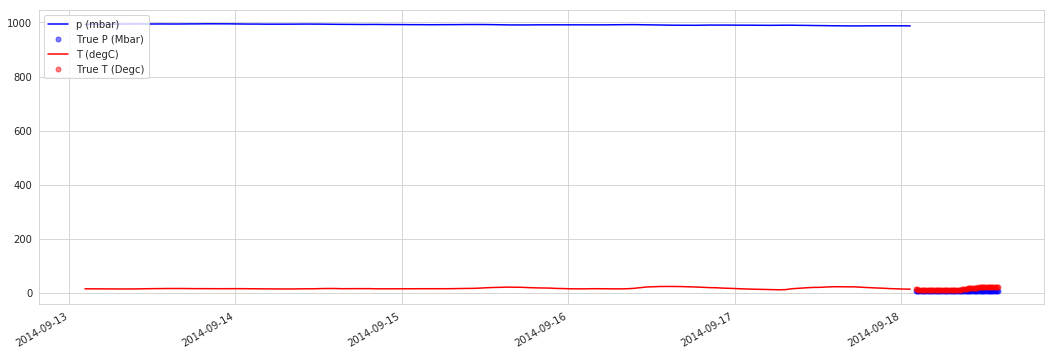

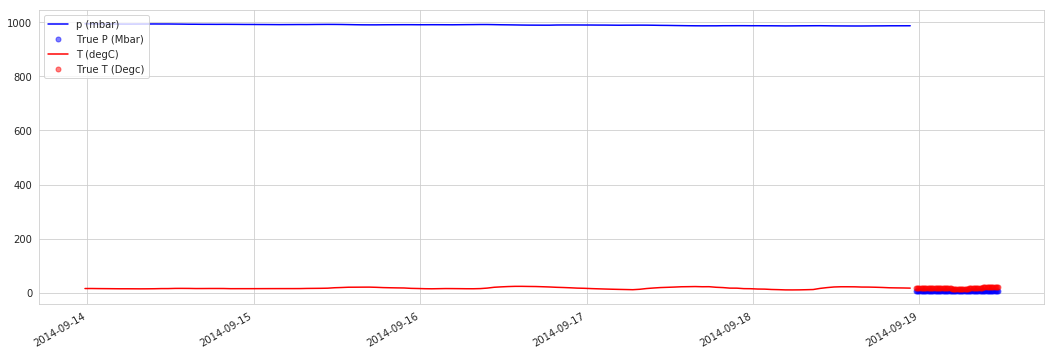

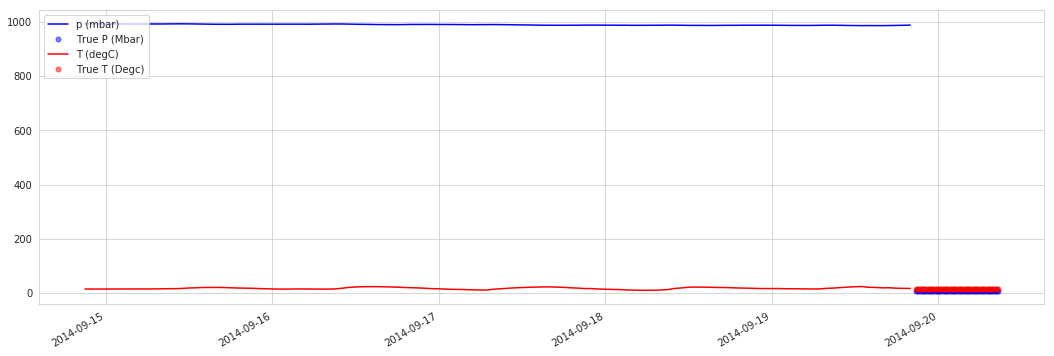

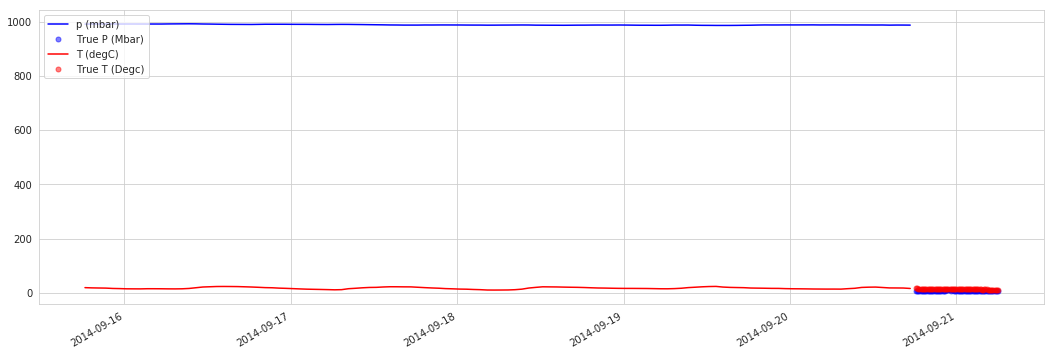

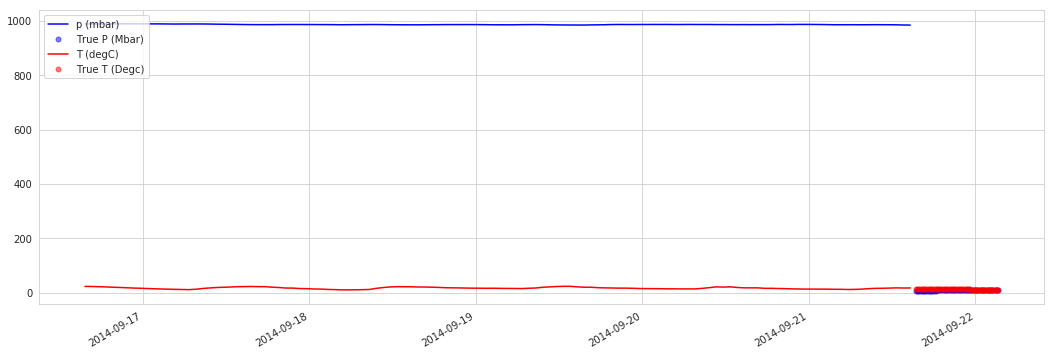

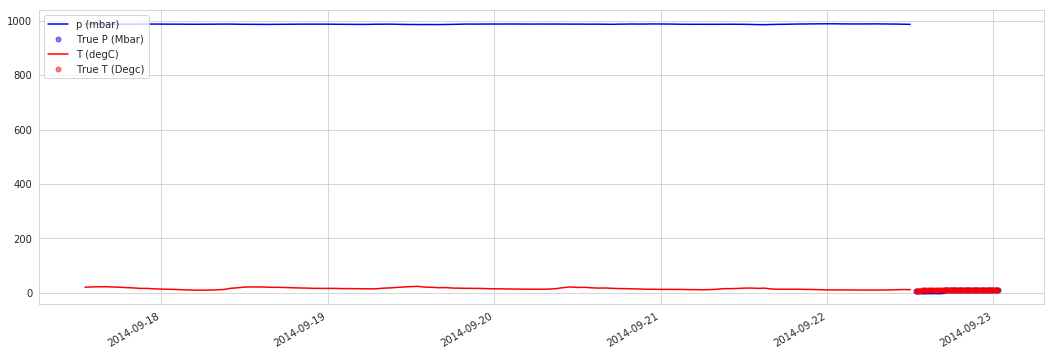

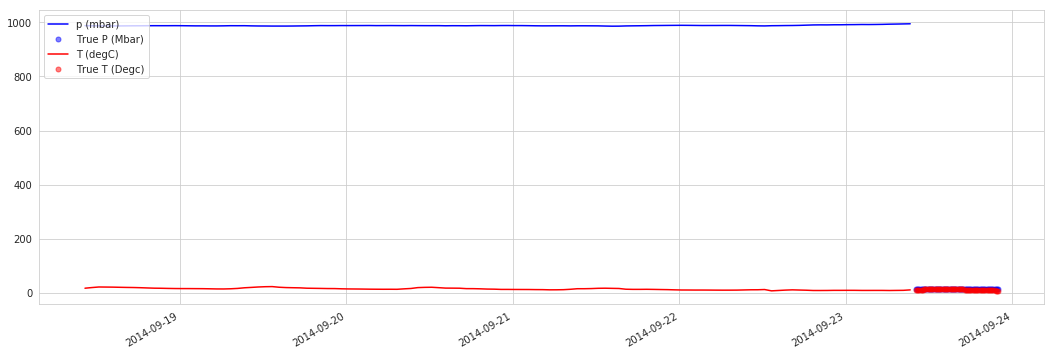

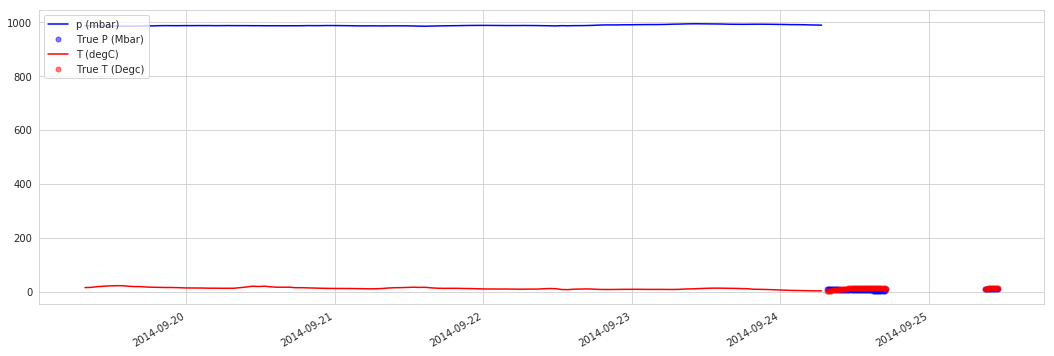

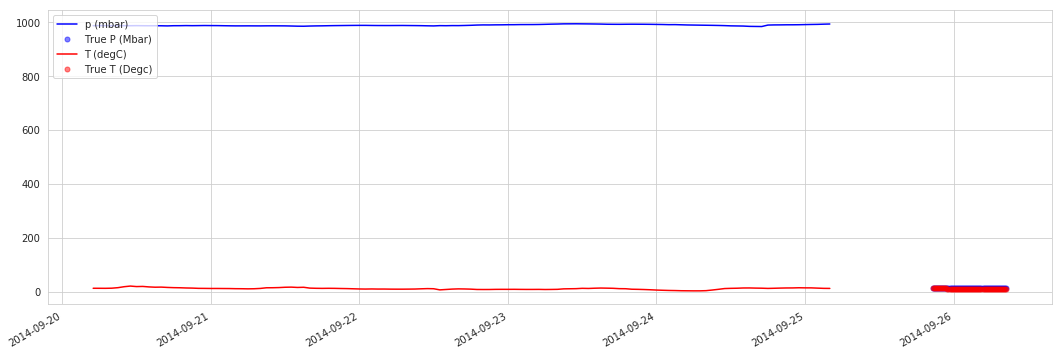

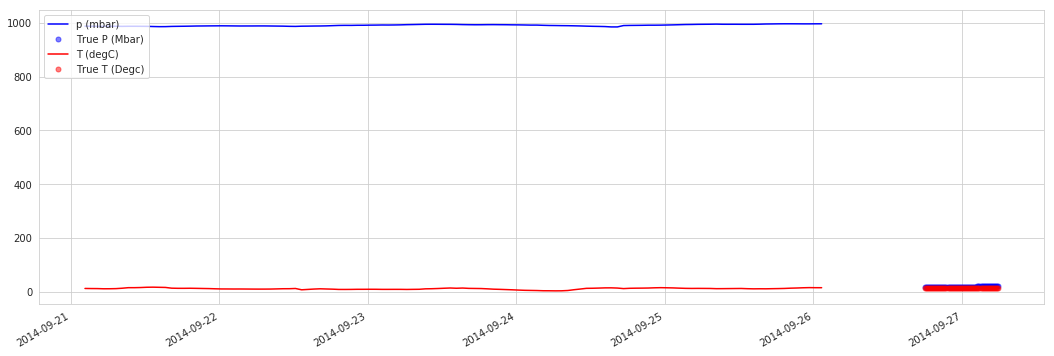

In [78]:
i=0
for x, y in val_data_multi.take(10):
    i=i+1
    #step=[0,single_step_model.predict(x).shape[0],single_step_model.predict(x).shape[0]*2]
    date_starte=int(TRAIN_SPLIT+BATCH_SIZE*(i-1))
    date_end=int(TRAIN_SPLIT+BATCH_SIZE*(i-1)+past_history-1)
    date_history = pd.date_range(date_time[date_starte],date_time[date_end], freq=' H ')
    date_history=date_history[:120]
    date_preduction=date_1[date_end:date_end+future_target]
    #print(len(date_preduction))
    multi_step_output_plot1(np.squeeze(x[0]), np.squeeze(y[0]), np.array([0]),date_history,date_preduction)


Simplified the Convolutional LSTM


Multi-Step, Multi-Input, and Multi-Output